# Import Dependencies

In [2]:
import math
import numpy as np
from numpy import sort
import pandas as pd
import pickle
import time
import random
from scipy import stats 

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
sns.set(style='white', palette = 'Paired')
#plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
np.set_printoptions(suppress=True) # Suppress scientific notation where possible
from ipywidgets import interactive, FloatSlider

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import OneHotEncoder

# Import Data

In [29]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [30]:
df.shape

(1460, 81)

In [31]:
df.iloc[-1:]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [32]:
df_test.shape

(1459, 80)

In [33]:
df_test.iloc[-1:]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [34]:
# Combine test and train to perform preprocessing for consistency. 
# Remove SalePrice for now, insert it back before fitting data to models.

df_new = pd.concat([df, df_test], axis=0)
df_new.reset_index(drop=True, inplace=True)
y = df['SalePrice']
df_new.drop(columns='SalePrice', inplace=True)

In [35]:
df_new

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


# EDA

In [36]:
# Drop Id column

# df.drop(columns='Id', inplace=True)
# df_test.drop(columns='Id', inplace=True)
df_new.drop(columns='Id', inplace=True)

In [37]:
# Split YearBuilt to 'new' = 1, 'old' = 0

# df['YearBuilt'] = np.array([1 if x >= 1999 else 0 for x in df['YearBuilt']])
# df_test['YearBuilt'] = np.array([1 if x >= 1999 else 0 for x in df_test['YearBuilt']])
df_new['YearBuilt'] = np.array([1 if x >= 1999 else 0 for x in df_new['YearBuilt']])

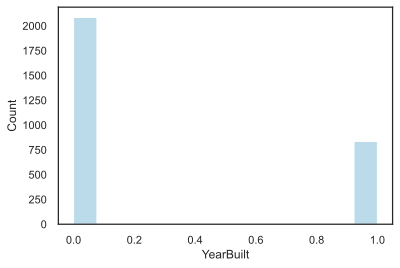

In [38]:
sns.histplot(df_new['YearBuilt']);

In [39]:
# Alley, PoolQC and MiscFeature have very little values in their column, so let;s go ahead and remove those columns

# df.drop(columns=['Alley', 'PoolQC', 'MiscFeature'], inplace=True)
# df_test.drop(columns=['Alley', 'PoolQC', 'MiscFeature'], inplace=True)
df_new.drop(columns=['Alley', 'PoolQC', 'MiscFeature'], inplace=True)

In [40]:
# Let's fill in the NaNs with the mean for numerical columns

# df.fillna(value=df.mean(), inplace=True)
# df_test.fillna(value=df_test.mean(), inplace=True)
df_new.fillna(value=df_new.mean(), inplace=True)

In [41]:
# Establish catericals and numericals and put column names in 2 lists

# categoricals = list(df.select_dtypes(include='object').columns)
# categoricals_test = list(df_test.select_dtypes(include='object').columns)

# numericals = list(df.select_dtypes(include='number').columns)
# numericals_test = list(df_test.select_dtypes(include='number').columns)

categoricals = list(df_new.select_dtypes(include='object').columns)
numericals = list(df_new.select_dtypes(include='number').columns)

In [42]:
print(len(categoricals))
print(len(numericals))

40
36


In [43]:
def fill_categoricals(df, categoricals, numericals):
    """
    Take in a dataframe, categorical columns list, numerical columns list, and returns a dataframe with the NaN values replaced with random categorical values for each column
    """
    
    # Let's replace categorical values with random values for each of the columns
    count = df.isna().sum().sum()
    
    while count > 0:
        
        for column in list(df[categoricals].columns):
            # Creates a random permutation of the categorical calues
            permutation = np.random.permutation(df[column])

            # Erase the empty values
            is_empty = np.where(permutation == "")
            permutation = np.delete(permutation, is_empty)

            # Replace all empty values of the dataframe
            end = len(permutation)
            df[column] = df[column].apply(lambda x: permutation[np.random.randint(end)] if pd.isnull(x) else x)
            
        count = df.isna().sum().sum()

In [44]:
# fill_categoricals(df, categoricals, numericals)
# fill_categoricals(df_test, categoricals_test, numericals_test)
fill_categoricals(df_new, categoricals, numericals)

In [45]:
# print(df.isna().sum().sum())
# print(df_test.isna().sum().sum())
print(df_new.isna().sum().sum())

0


In [46]:
# print(df.shape)
# print(df_test.shape)
print(df_new.shape)

(2919, 76)


In [47]:
# Encode categorical columns

def encode_cats(df, categoricals, numericals):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(df.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=df.index) #keep the same index values
    
    return pd.concat([df.loc[:, numericals], X_ohe], axis=1)

In [48]:
# df = encode_cats(df, categoricals, numericals)
# df_test = encode_cats(df_test, categoricals_test, numericals_test)
df_new = encode_cats(df_new, categoricals, numericals)

In [49]:
df_new.shape

(2919, 239)

In [50]:
df_new.iloc[1459]

MSSubClass                 20.0
LotFrontage                75.0
LotArea                  9937.0
OverallQual                 5.0
OverallCond                 6.0
                          ...  
SaleCondition_AdjLand       0.0
SaleCondition_Alloca        0.0
SaleCondition_Family        0.0
SaleCondition_Normal        1.0
SaleCondition_Partial       0.0
Name: 1459, Length: 239, dtype: float64

In [51]:
df_new['SalePrice'] = y

In [52]:
df_new

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,60,65.0,8450,7,5,1,2003,196.0,706.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,208500.0
1,20,80.0,9600,6,8,0,1976,0.0,978.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,181500.0
2,60,68.0,11250,7,5,1,2002,162.0,486.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,223500.0
3,70,60.0,9550,7,5,0,1970,0.0,216.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,140000.0
4,60,84.0,14260,8,5,1,2000,350.0,655.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,7,0,1970,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN
2915,160,21.0,1894,4,5,0,1970,0.0,252.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
2916,20,160.0,20000,5,7,0,1996,0.0,1224.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
2917,85,62.0,10441,5,5,0,1992,0.0,337.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN


In [53]:
df_new.iloc[1459:]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
1459,20,75.0,9937,5,6,0,1965,0.0,830.0,290.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,147500.0
1460,20,80.0,11622,5,6,0,1961,0.0,468.0,144.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN
1461,20,81.0,14267,6,6,0,1958,108.0,923.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN
1462,60,74.0,13830,5,5,0,1998,0.0,791.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN
1463,60,78.0,9978,6,6,0,1998,20.0,602.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,7,0,1970,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN
2915,160,21.0,1894,4,5,0,1970,0.0,252.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
2916,20,160.0,20000,5,7,0,1996,0.0,1224.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
2917,85,62.0,10441,5,5,0,1992,0.0,337.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN


# Base Model

In [54]:
def test_train_split(X, y):
    """
    Takes the feature and target data and returns the test_train splits.
    Then, X and y and converted to np.array so it can be used in kf function below
    """

    # hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True)

    # this helps with the way kf will generate indices below
    X, y = np.array(X), np.array(y)

    return X, X_test, y, y_test

In [64]:
def scale_X_test(X_test):
    """
    Takes in a dataframe of X_test features and scales them
    """

    # Scale features and test data

    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)

    return X_test_scaled

In [65]:
def regression_analysis(X, X_test, y, y_test):
        """
        Conducts regression anlaysls. Prints R-squared and MAE for each algorithm
        """
        kf = KFold(n_splits=5, shuffle=True, random_state = 42)
        lr_scores, lr_ridge_scores, lr_lasso_scores, \
        lr_elastic_scores, lr_xgb_scores, lr_rf_scores = [], [], [], [], [], [] #collect the validation results for all models

        for train_ind, val_ind in kf.split(X,y):

            X_train, y_train = X[train_ind], y[train_ind]
            X_val, y_val = X[val_ind], y[val_ind] 

            # scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            # load models
            lr = LinearRegression()
            lr_ridge = RidgeCV(cv=5)
            lr_lasso = LassoCV(cv=5, tol=0.5, max_iter=50000)
            lr_elastic = ElasticNetCV(cv=5, random_state=42, tol=0.5, max_iter=50000)
            lr_xgb = XGBRegressor(n_estimators=150, learning_rate=0.15)
            lr_rf = RandomForestRegressor()

            # fit models
            lr.fit(X_train_scaled, y_train)
            lr_ridge.fit(X_train_scaled, y_train)
            lr_lasso.fit(X_train_scaled, y_train)
            lr_elastic.fit(X_train_scaled, y_train)
            lr_rf.fit(X_train_scaled, y_train)
            lr_xgb.fit(X_train_scaled, y_train)

            # create lists of scores
            lr_scores.append(lr.score(X_val_scaled, y_val))
            lr_ridge_scores.append(lr_ridge.score(X_val_scaled, y_val))
            lr_lasso_scores.append(lr_lasso.score(X_val_scaled, y_val))
            lr_elastic_scores.append(lr_elastic.score(X_val_scaled, y_val))
            lr_rf_scores.append(lr_rf.score(X_val_scaled, y_val))
            lr_xgb_scores.append(lr_xgb.score(X_val_scaled, y_val))
            
        # Test
        
        # Prints all of our metrics
        
        print(f'Linear Regression val R^2: {np.mean(lr_scores):.3f} +- {np.std(lr_scores):.3f}')
        print(f'Linear Regression test R^2: {lr.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test_scaled), squared=False):.3f}\n')
        
        print(f'Ridge Regression val R^2: {np.mean(lr_ridge_scores):.3f} +- {np.std(lr_ridge_scores):.3f}')
        print(f'Ridge Regression test R^2: {lr_ridge.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr_ridge.predict(X_test_scaled), squared=False):.3f}\n')

        print(f'Lasso Regression val R^2: {np.mean(lr_lasso_scores):.3f} +- {np.std(lr_lasso_scores):.3f}')
        print(f'Lasso Regression test R^2: {lr_lasso.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr_lasso.predict(X_test_scaled), squared=False):.3f}\n')

        print(f'Elastic Net Regression val R^2: {np.mean(lr_elastic_scores):.3f} +- {np.std(lr_elastic_scores):.3f}')
        print(f'Elastic Net Regression test R^2: {lr_elastic.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr_elastic.predict(X_test_scaled), squared=False):.3f}\n')

        print(f'Random Forest Regression val R^2: {np.mean(lr_rf_scores):.3f} +- {np.std(lr_rf_scores):.3f}')
        print(f'Random Forest Regression test R^2: {lr_rf.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr_rf.predict(X_test_scaled), squared=False):.3f}\n')

        print(f'XGBoost Regression val R^2: {np.mean(lr_xgb_scores):.3f} +- {np.std(lr_xgb_scores):.3f}')
        print(f'XGBoost Regression test R^2: {lr_xgb.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr_xgb.predict(X_test_scaled), squared=False):.3f}')
        
        # Put models and respective scores in a list
        
        model_score_list = [[lr, lr.score(X_test_scaled, y_test)],
                   [lr_ridge, lr_ridge.score(X_test_scaled, y_test)],
                   [lr_lasso, lr_lasso.score(X_test_scaled, y_test)],
                   [lr_elastic, lr_elastic.score(X_test_scaled, y_test)],
                   [lr_xgb, lr_xgb.score(X_test_scaled, y_test)]]
        
        model_score_list = sorted(model_score_list, key = lambda x: x[1])
        
        # Return model with highest R-squared
        
        return model_score_list[-1][0]

In [66]:
def plot_residuals(model):
    """
    Residuals v Predicted plot
    """

    residuals = y_test - model.predict(X_test_scaled)

    plt.figure(figsize=(10, 7))
    plt.scatter(model.predict(X_test_scaled), residuals)   

    plt.axhline(0, linestyle='--', color='gray')
    plt.xlabel('Predicted Values', fontsize=18)
    plt.ylabel('Residuals', fontsize=18);

In [75]:
# Establish features and target

X = df_new.drop(columns='SalePrice').iloc[:1459,:]
X_pred = df_new.drop(columns='SalePrice').iloc[1460:,:] # We will predict on this dataset

y = df['SalePrice'][:1459]

In [68]:
X, X_test, y, y_test = test_train_split(X, y)

In [69]:
X_test_scaled = scale_X_test(X_test)

In [70]:
model  = regression_analysis(X, X_test, y, y_test)

Linear Regression val R^2: -4040273922045114843136.000 +- 7517109959253908520960.000
Linear Regression test R^2: -33565145536386721382400.000
RMSE: 13285627415095374.000

Ridge Regression val R^2: 0.649 +- 0.193
Ridge Regression test R^2: 0.781
RMSE: 33959.020

Lasso Regression val R^2: 0.632 +- 0.218
Lasso Regression test R^2: 0.838
RMSE: 29158.564

Elastic Net Regression val R^2: 0.231 +- 0.009
Elastic Net Regression test R^2: 0.278
RMSE: 61614.931

Random Forest Regression val R^2: 0.820 +- 0.099
Random Forest Regression test R^2: 0.870
RMSE: 26114.576

XGBoost Regression val R^2: 0.807 +- 0.115
XGBoost Regression test R^2: 0.885
RMSE: 24637.533


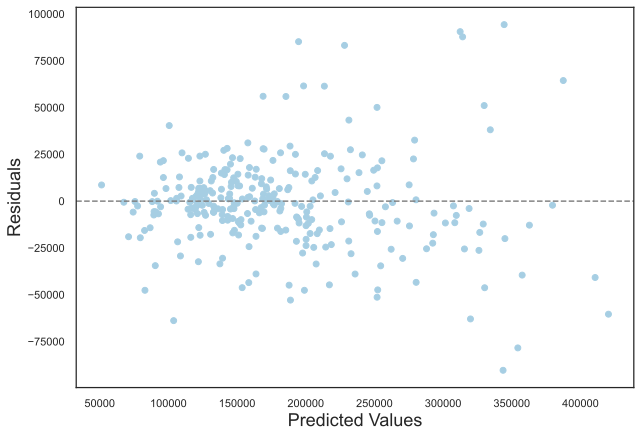

In [71]:
plot_residuals(model)

# Make Predictions

In [78]:
scaler = StandardScaler()

In [79]:
X_pred_scaled = scaler.fit_transform(X_pred)

In [113]:
predictions = model.predict(X_pred_scaled)

In [114]:
pred_dict = {'SalePrice': predictions}

In [119]:
submission = pd.DataFrame(pred_dict, index=range(1461,2920), dtype=np.int64)

In [121]:
submission.to_csv('submission.csv')